In [1]:
%%capture
!pip install k-wave-python

In [2]:
import matplotlib.pyplot as plt
import numpy as np

import kwave.data
from kwave.kWaveSimulation import SimulationOptions
from kwave.kgrid import kWaveGrid
from kwave.kmedium import kWaveMedium
from kwave.ksensor import kSensor
from kwave.ksource import kSource
from kwave.kspaceFirstOrder3D import kspaceFirstOrder3DC
from kwave.options.simulation_execution_options import SimulationExecutionOptions
from kwave.utils.kwave_array import kWaveArray
from kwave.utils.plot import voxel_plot
from kwave.utils.signals import tone_burst

In [3]:
# Define constants
c0 = 1500
rho0 = 1000
source_f0 = 1e6
source_amp = 1e6
source_cycles = 5
source_focus = 20e-3
element_num = 15
element_width = 1e-3
element_length = 10e-3
element_pitch = 2e-3
translation = kwave.data.Vector([5e-3, 0, 8e-3])
rotation = kwave.data.Vector([0, 20, 0])
grid_size_x = 40e-3
grid_size_y = 20e-3
grid_size_z = 40e-3
ppw = 3
t_end = 35e-6
cfl = 0.5


In [4]:
%%capture
# GRID
dx = c0 / (ppw * source_f0)
Nx = round(grid_size_x / dx)
Ny = round(grid_size_y / dx)
Nz = round(grid_size_z / dx)
kgrid = kWaveGrid([Nx, Ny, Nz], [dx, dx, dx])
kgrid.makeTime(c0, cfl, t_end)

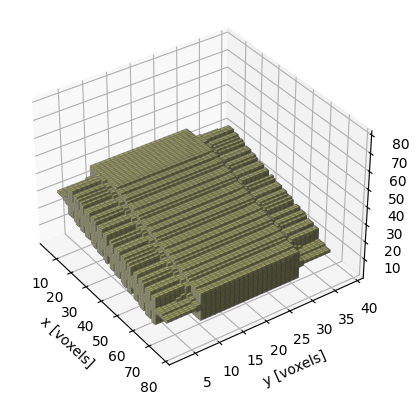

In [5]:
# SOURCE
if element_num % 2 != 0:
    ids = np.arange(1, element_num + 1) - np.ceil(element_num / 2)
else:
    ids = np.arange(1, element_num + 1) - (element_num + 1) / 2

time_delays = -(np.sqrt((ids * element_pitch) ** 2 + source_focus ** 2) - source_focus) / c0
time_delays = time_delays - min(time_delays)

source_sig = source_amp * tone_burst(1 / kgrid.dt, source_f0, source_cycles,
                                      signal_offset=np.round(time_delays / kgrid.dt).astype(int))
karray = kWaveArray(bli_tolerance=0.05, upsampling_rate=10)

for ind in range(element_num):
    x_pos = 0 - (element_num * element_pitch / 2 - element_pitch / 2) + ind * element_pitch
    karray.add_rect_element([x_pos, 0, kgrid.z_vec[0][0]], element_width, element_length, rotation)

karray.set_array_position(translation, rotation)
source = kSource()
source.p_mask = karray.get_array_binary_mask(kgrid)
%matplotlib inline
voxel_plot(np.single(source.p_mask))
source.p = karray.get_distributed_source_signal(kgrid, source_sig)


In [6]:
# MEDIUM
medium = kWaveMedium(sound_speed=c0, density=rho0)


In [7]:
# SENSOR
sensor_mask = np.zeros((Nx, Ny, Nz))
sensor_mask[:, Ny // 2, :] = 1
sensor = kSensor(sensor_mask, record=['p_max'])

In [8]:
# SIMULATION
simulation_options = SimulationOptions(
    pml_auto=True,
    pml_inside=False,
    save_to_disk=True,
    data_cast='single',
)

execution_options = SimulationExecutionOptions(is_gpu_simulation=True)

sensor_data = kspaceFirstOrder3DC(kgrid=kgrid, medium=medium, source=source, sensor=sensor,
                                  simulation_options=simulation_options, execution_options=execution_options)

p_max = np.reshape(sensor_data['p_max'], (Nx, Nz), order='F')


┌───────────────────────────────────────────────────────────────┐
│                  kspaceFirstOrder-CUDA v1.3                   │
├───────────────────────────────────────────────────────────────┤
│ Reading simulation configuration:                        Done │
│ Selected GPU device id:                                

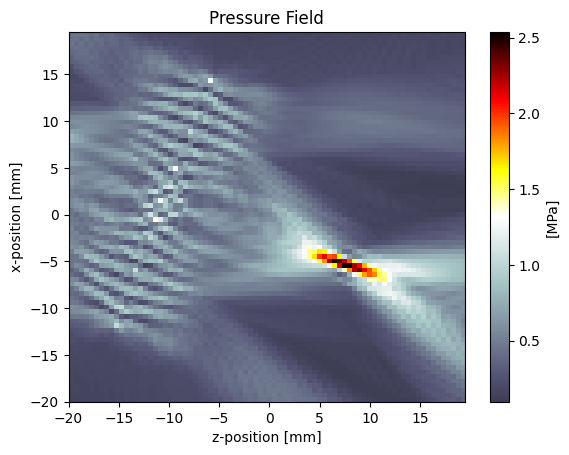

In [12]:
# VISUALISATION
plt.figure()
plt.imshow(1e-6 * p_max, extent=[1e3 * kgrid.x_vec[0][0], 1e3 * kgrid.x_vec[-1][0], 1e3 * kgrid.z_vec[0][0],
                                  1e3 * kgrid.z_vec[-1][0]], aspect='auto', cmap=kwave.utils.colormap.get_color_map())
plt.xlabel('z-position [mm]')
plt.ylabel('x-position [mm]')
plt.title('Pressure Field')
plt.colorbar(label='[MPa]')
plt.show()
